# MovieLens - Predicting a user's gender based on the movies they have watched

In this notebook, we will apply getML to a dataset that is often used for benchmarking in the relational learning literature: The MovieLens dataset.

Summary:

- Prediction type: __Classification model__
- Domain: __Entertainment__
- Prediction target: __The gender of a user__ 
- Population size: __6039__

## Background

The MovieLens dataset is often used in the relational learning literature has a benchmark for newly developed algorithms. Following the tradition, we benchmark getML's own algorithms on this dataset as well. The task is to predict a user's gender based on the movies they have watched.


It has been downloaded from the [CTU Prague relational learning repository](https://relational.fit.cvut.cz/dataset/MovieLens) (Motl and Schulte, 2015) (Now residing at [relational-data.org](https://relational-data.org/dataset/MovieLens).).

## Analysis

Let's get started with the analysis and set up your session:

In [1]:
import copy
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"
from pathlib import Path

from urllib import request

import numpy as np
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

import getml

getml.engine.launch(home_directory=Path.home(), allow_remote_ips=True, token='token')
getml.engine.set_project('MovieLens')

getML engine is already running.

Connected to project 'MovieLens'


### 1. Loading data

#### 1.1 Download from source

We begin by downloading the data from the source file:

In [2]:
conn = getml.database.connect_mysql(
    host="db.relational-data.org",
    dbname="imdb_MovieLens",
    port=3306,
    user="guest",
    password="relational"
)

conn

Connection(dbname='imdb_MovieLens',
           dialect='mysql',
           host='db.relational-data.org',
           port=3306)

In [3]:
def load_if_needed(name):
    """
    Loads the data from the relational learning
    repository, if the data frame has not already
    been loaded.
    """
    if not getml.data.exists(name):
        data_frame = getml.data.DataFrame.from_db(
            name=name,
            table_name=name,
            conn=conn
        )
        data_frame.save()
    else:
        data_frame = getml.data.load_data_frame(name)
    return data_frame

In [4]:
users = load_if_needed("users")
u2base = load_if_needed("u2base")
movies = load_if_needed("movies")
movies2directors = load_if_needed("movies2directors")
directors = load_if_needed("directors")
movies2actors = load_if_needed("movies2actors")
actors = load_if_needed("actors")

#### 1.2 Prepare data for getML

getML requires that we define *roles* for each of the columns.

In [5]:
users["target"] = (users.u_gender == 'F')

In [6]:
users.set_role("userid", getml.data.roles.join_key)
users.set_role("age", getml.data.roles.numerical)
users.set_role("occupation", getml.data.roles.categorical)
users.set_role("target", getml.data.roles.target)

users.save()

name,userid,target,occupation,age,u_gender
role,join_key,target,categorical,numerical,unused_string
0,1,1,2,1,F
1,51,1,2,1,F
2,75,1,2,1,F
3,86,1,2,1,F
4,99,1,2,1,F
,...,...,...,...,...
6034,5658,0,5,56,M
6035,5669,0,5,56,M
6036,5703,0,5,56,M


In [7]:
u2base.set_role(["userid", "movieid"], getml.data.roles.join_key)
u2base.set_role("rating", getml.data.roles.numerical)

u2base.save()

name,userid,movieid,rating
role,join_key,join_key,numerical
0,2,1964242,1
1,2,2219779,1
2,3,1856939,1
3,4,2273044,1
4,5,1681655,1
,...,...,...
996154,6040,2560616,5
996155,6040,2564194,5
996156,6040,2581228,5


In [8]:
movies.set_role("movieid", getml.data.roles.join_key)
movies.set_role(["year", "runningtime"], getml.data.roles.numerical)
movies.set_role(["isEnglish", "country"], getml.data.roles.categorical)

movies.save()

name,movieid,isEnglish,country,year,runningtime
role,join_key,categorical,categorical,numerical,numerical
0,1672052,T,other,3,2
1,1672111,T,other,4,2
2,1672580,T,USA,4,3
3,1672716,T,USA,4,2
4,1672946,T,USA,4,0
,...,...,...,...,...
3827,2591814,T,other,4,2
3828,2592334,T,USA,4,2
3829,2592963,F,France,2,2


In [9]:
movies2directors.set_role(["movieid", "directorid"], getml.data.roles.join_key)
movies2directors.set_role( "genre", getml.data.roles.categorical)

movies2directors.save()

name,movieid,directorid,genre
role,join_key,join_key,categorical
0,1672111,54934,Action
1,1672946,188940,Action
2,1679461,179783,Action
3,1691387,291700,Action
4,1693305,14663,Action
,...,...,...
4136,2570825,265215,Other
4137,2572478,149311,Other
4138,2577062,304827,Other


In [10]:
directors.set_role("directorid", getml.data.roles.join_key)
directors.set_role(["d_quality", "avg_revenue"], getml.data.roles.numerical)

directors.save()

name,directorid,d_quality,avg_revenue
role,join_key,numerical,numerical
0,67,4,1
1,92,2,3
2,284,4,0
3,708,4,1
4,746,4,4
,...,...,...
2196,305962,4,4
2197,305978,4,2
2198,306168,3,2


In [11]:
movies2actors.set_role(["movieid", "actorid"], getml.data.roles.join_key)
movies2actors.set_role( "cast_num", getml.data.roles.numerical)

movies2actors.save()

name,movieid,actorid,cast_num
role,join_key,join_key,numerical
0,1672580,981535,0
1,1672946,1094968,0
2,1673647,149985,0
3,1673647,261595,0
4,1673647,781357,0
,...,...,...
138344,2593313,947005,3
138345,2593313,1090590,3
138346,2593313,1347419,3


We need to separate our data set into a training, testing and validation set:

In [12]:
actors.set_role("actorid", getml.data.roles.join_key)
actors.set_role("a_quality", getml.data.roles.numerical)
actors.set_role("a_gender", getml.data.roles.categorical)

actors.save()

name,actorid,a_gender,a_quality
role,join_key,categorical,numerical
0,4,M,4
1,16,M,0
2,28,M,4
3,566,M,4
4,580,M,4
,...,...,...
98685,2749162,F,3
98686,2749168,F,3
98687,2749204,F,3


In [13]:
split = getml.data.split.random(train=0.75, test=0.25)
split

,
0,train
1,train
2,train
3,test
4,test
,...


In [14]:
container = getml.data.Container(population=users, split=split)

container.add(
    u2base=u2base,
    movies=movies,
    movies2directors=movies2directors,
    directors=directors,
    movies2actors=movies2actors,
    actors=actors,
)

container

population
    subset   name    rows   type
0   test     users   1511   View
1   train    users   4528   View

peripheral
    name                 rows   type     
0   u2base             996159   DataFrame
1   movies               3832   DataFrame
2   movies2directors     4141   DataFrame
3   directors            2201   DataFrame
4   movies2actors      138349   DataFrame
5   actors              98690   DataFrame

### 2. Predictive modeling

We loaded the data and defined the roles and units. Next, we create a getML pipeline for relational learning.

#### 2.1 Define relational model

To get started with relational learning, we need to specify the data model.

In [15]:
dm = getml.data.DataModel(users.to_placeholder())

dm.add(getml.data.to_placeholder(
    u2base=u2base,
    movies=movies,
    movies2directors=movies2directors,
    directors=directors,
    movies2actors=movies2actors,
    actors=actors,
))

dm.population.join(
    dm.u2base,
    on='userid'
)

dm.u2base.join(
    dm.movies,
    on='movieid',
    relationship=getml.data.relationship.many_to_one
)

dm.movies.join(
    dm.movies2directors,
    on='movieid',
    relationship=getml.data.relationship.propositionalization
)

dm.movies2directors.join(
    dm.directors,
    on='directorid',
    relationship=getml.data.relationship.many_to_one
)

dm.movies.join(
    dm.movies2actors,
    on='movieid',
    relationship=getml.data.relationship.propositionalization
)

dm.movies2actors.join(
    dm.actors,
    on='actorid',
    relationship=getml.data.relationship.many_to_one
)

dm

,data frames,staging table
0,users,USERS__STAGING_TABLE_1
1,"movies2actors, actors",MOVIES2ACTORS__STAGING_TABLE_2
2,"movies2directors, directors",MOVIES2DIRECTORS__STAGING_TABLE_3
3,"u2base, movies",U2BASE__STAGING_TABLE_4


#### 2.2 getML pipeline

<!-- #### 2.1.1  -->
__Set-up the feature learner & predictor__

We will set up two pipelines. One of them uses `FastProp`, the other one uses `Relboost`. Note that we have marked some of the joins in the data model with the `propositionalization` tag. This means that `FastProp` will be used for these relationships, even for the second pipeline. This can significantly speed up the training process.

In [16]:
mapping = getml.preprocessors.Mapping()

fast_prop = getml.feature_learning.FastProp(
    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
    num_threads=1,
)

relboost = getml.feature_learning.Relboost(
    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
    num_subfeatures=50,
    num_threads=1
)

predictor = getml.predictors.XGBoostClassifier(
    max_depth=5,
    n_jobs=1,
)

__Build the pipeline__

In [17]:
pipe1 = getml.pipeline.Pipeline(
    tags=['fast_prop'],
    data_model=dm,
    preprocessors=[mapping],
    feature_learners=[fast_prop],
    predictors=[predictor]
)

pipe1

Pipeline(data_model='users',
         feature_learners=['FastProp'],
         feature_selectors=[],
         include_categorical=False,
         loss_function='CrossEntropyLoss',
         peripheral=['actors', 'directors', 'movies', 'movies2actors', 'movies2directors',
                     'u2base'],
         predictors=['XGBoostClassifier'],
         preprocessors=['Mapping'],
         share_selected_features=0.5,
         tags=['fast_prop'])

In [18]:
pipe2 = getml.pipeline.Pipeline(
    tags=['relboost'],
    data_model=dm,
    preprocessors=[mapping],
    feature_learners=[relboost],
    predictors=[predictor]
)

pipe2

Pipeline(data_model='users',
         feature_learners=['Relboost'],
         feature_selectors=[],
         include_categorical=False,
         loss_function='CrossEntropyLoss',
         peripheral=['actors', 'directors', 'movies', 'movies2actors', 'movies2directors',
                     'u2base'],
         predictors=['XGBoostClassifier'],
         preprocessors=['Mapping'],
         share_selected_features=0.5,
         tags=['relboost'])

#### 2.3 Model training

In [19]:
pipe1.check(container.train)

Checking data model...
Staging... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Preprocessing... 100% |██████████| [elapsed: 00:08, remaining: 00:00]          
Checking... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          

The pipeline check generated 2 issues labeled INFO and 0 issues labeled WARNING.


,type,label,message
0,INFO,FOREIGN KEYS NOT FOUND,"When joining U2BASE__STAGING_TABLE_4 and MOVIES2DIRECTORS__STAGING_TABLE_3 over 'movieid' and 'movieid', there are no corresponding entries for 0.159513% of entries in 'movieid' in 'U2BASE__STAGING_TABLE_4'. You might want to double-check your join keys."
1,INFO,FOREIGN KEYS NOT FOUND,"When joining U2BASE__STAGING_TABLE_4 and MOVIES2ACTORS__STAGING_TABLE_2 over 'movieid' and 'movieid', there are no corresponding entries for 0.340408% of entries in 'movieid' in 'U2BASE__STAGING_TABLE_4'. You might want to double-check your join keys."


In [20]:
pipe1.fit(container.train)

Checking data model...
Staging... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Preprocessing... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          

The pipeline check generated 2 issues labeled INFO and 0 issues labeled WARNING.
To see the issues in full, run .check() on the pipeline.

Staging... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Preprocessing... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
FastProp: Trying 941 features... 100% |██████████| [elapsed: 00:43, remaining: 00:00]          
FastProp: Building subfeatures... 100% |██████████| [elapsed: 00:23, remaining: 00:00]          
FastProp: Building features... 100% |██████████| [elapsed: 00:03, remaining: 00:00]          
XGBoost: Training as predictor... 100% |██████████| [elapsed: 00:05, remaining: 00:00]          

Trained pipeline.
Time taken: 0h:1m:13.926562



Pipeline(data_model='users',
         feature_learners=['FastProp'],
         feature_selectors=[],
         include_categorical=False,
         loss_function='CrossEntropyLoss',
         peripheral=['actors', 'directors', 'movies', 'movies2actors', 'movies2directors',
                     'u2base'],
         predictors=['XGBoostClassifier'],
         preprocessors=['Mapping'],
         share_selected_features=0.5,
         tags=['fast_prop', 'container-fr4Ui8'])

In [21]:
pipe2.check(container.train)

Checking data model...
Staging... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Preprocessing... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Checking... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          

The pipeline check generated 2 issues labeled INFO and 0 issues labeled WARNING.


,type,label,message
0,INFO,FOREIGN KEYS NOT FOUND,"When joining U2BASE__STAGING_TABLE_4 and MOVIES2DIRECTORS__STAGING_TABLE_3 over 'movieid' and 'movieid', there are no corresponding entries for 0.159513% of entries in 'movieid' in 'U2BASE__STAGING_TABLE_4'. You might want to double-check your join keys."
1,INFO,FOREIGN KEYS NOT FOUND,"When joining U2BASE__STAGING_TABLE_4 and MOVIES2ACTORS__STAGING_TABLE_2 over 'movieid' and 'movieid', there are no corresponding entries for 0.340408% of entries in 'movieid' in 'U2BASE__STAGING_TABLE_4'. You might want to double-check your join keys."


In [22]:
pipe2.fit(container.train)

Checking data model...
Staging... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Preprocessing... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          

The pipeline check generated 2 issues labeled INFO and 0 issues labeled WARNING.
To see the issues in full, run .check() on the pipeline.

Staging... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Preprocessing... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
FastProp: Building subfeatures... 100% |██████████| [elapsed: 00:05, remaining: 00:00]          
Relboost: Training features... 100% |██████████| [elapsed: 08:55, remaining: 00:00]          
FastProp: Building subfeatures... 100% |██████████| [elapsed: 00:05, remaining: 00:00]          
Relboost: Building features... 100% |██████████| [elapsed: 01:49, remaining: 00:00]          
XGBoost: Training as predictor... 100% |██████████| [elapsed: 00:04, remaining: 00:00]          

Trained pipeline.
Time taken: 0h:10m:58.115767



Pipeline(data_model='users',
         feature_learners=['Relboost'],
         feature_selectors=[],
         include_categorical=False,
         loss_function='CrossEntropyLoss',
         peripheral=['actors', 'directors', 'movies', 'movies2actors', 'movies2directors',
                     'u2base'],
         predictors=['XGBoostClassifier'],
         preprocessors=['Mapping'],
         share_selected_features=0.5,
         tags=['relboost', 'container-fr4Ui8'])

#### 2.4 Model evaluation

In [23]:
fastprop_score = pipe1.score(container.test)
fastprop_score

Staging... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Preprocessing... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
FastProp: Building subfeatures... 100% |██████████| [elapsed: 00:21, remaining: 00:00]          
FastProp: Building features... 100% |██████████| [elapsed: 00:01, remaining: 00:00]          



,date time,set used,target,accuracy,auc,cross entropy
0,2024-02-21 15:03:15,train,target,0.9114,0.9658,0.2847
1,2024-02-21 15:14:36,test,target,0.7776,0.7896,0.4757


In [24]:
relboost_score = pipe2.score(container.test)
relboost_score

Staging... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Preprocessing... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
FastProp: Building subfeatures... 100% |██████████| [elapsed: 00:05, remaining: 00:00]          
Relboost: Building features... 100% |██████████| [elapsed: 00:37, remaining: 00:00]          



,date time,set used,target,accuracy,auc,cross entropy
0,2024-02-21 15:14:14,train,target,0.966,0.9943,0.1609
1,2024-02-21 15:15:18,test,target,0.8101,0.8409,0.4384


#### 2.6 Studying features

__Column importances__

Because getML uses relational learning, we can apply the principles we used to calculate the feature importances to individual columns as well.

As we can see, most of the predictive accuracy is drawn from the roles played by the actors. This suggests that the text fields contained in this relational database have a higher impact on predictive accuracy than for most other data sets.

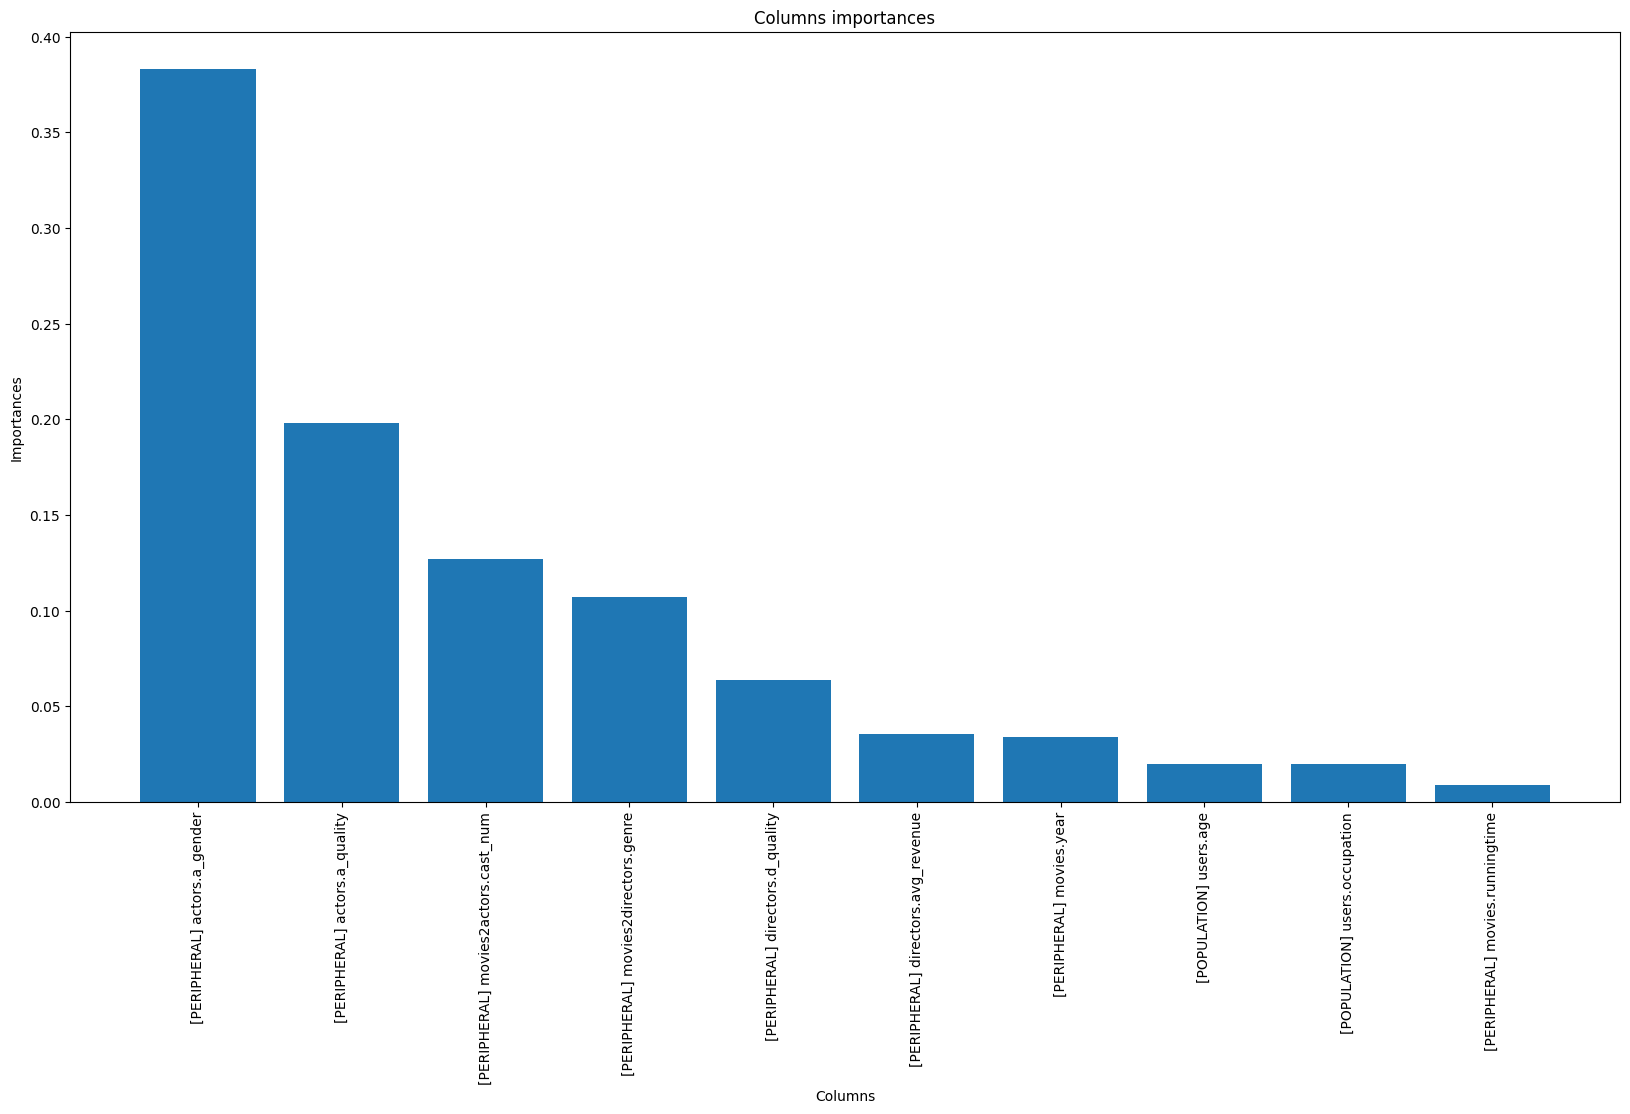

In [25]:
names, importances = pipe1.columns.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances)

plt.title('Columns importances')
plt.xlabel('Columns')
plt.ylabel('Importances')
plt.xticks(rotation='vertical')
plt.show()

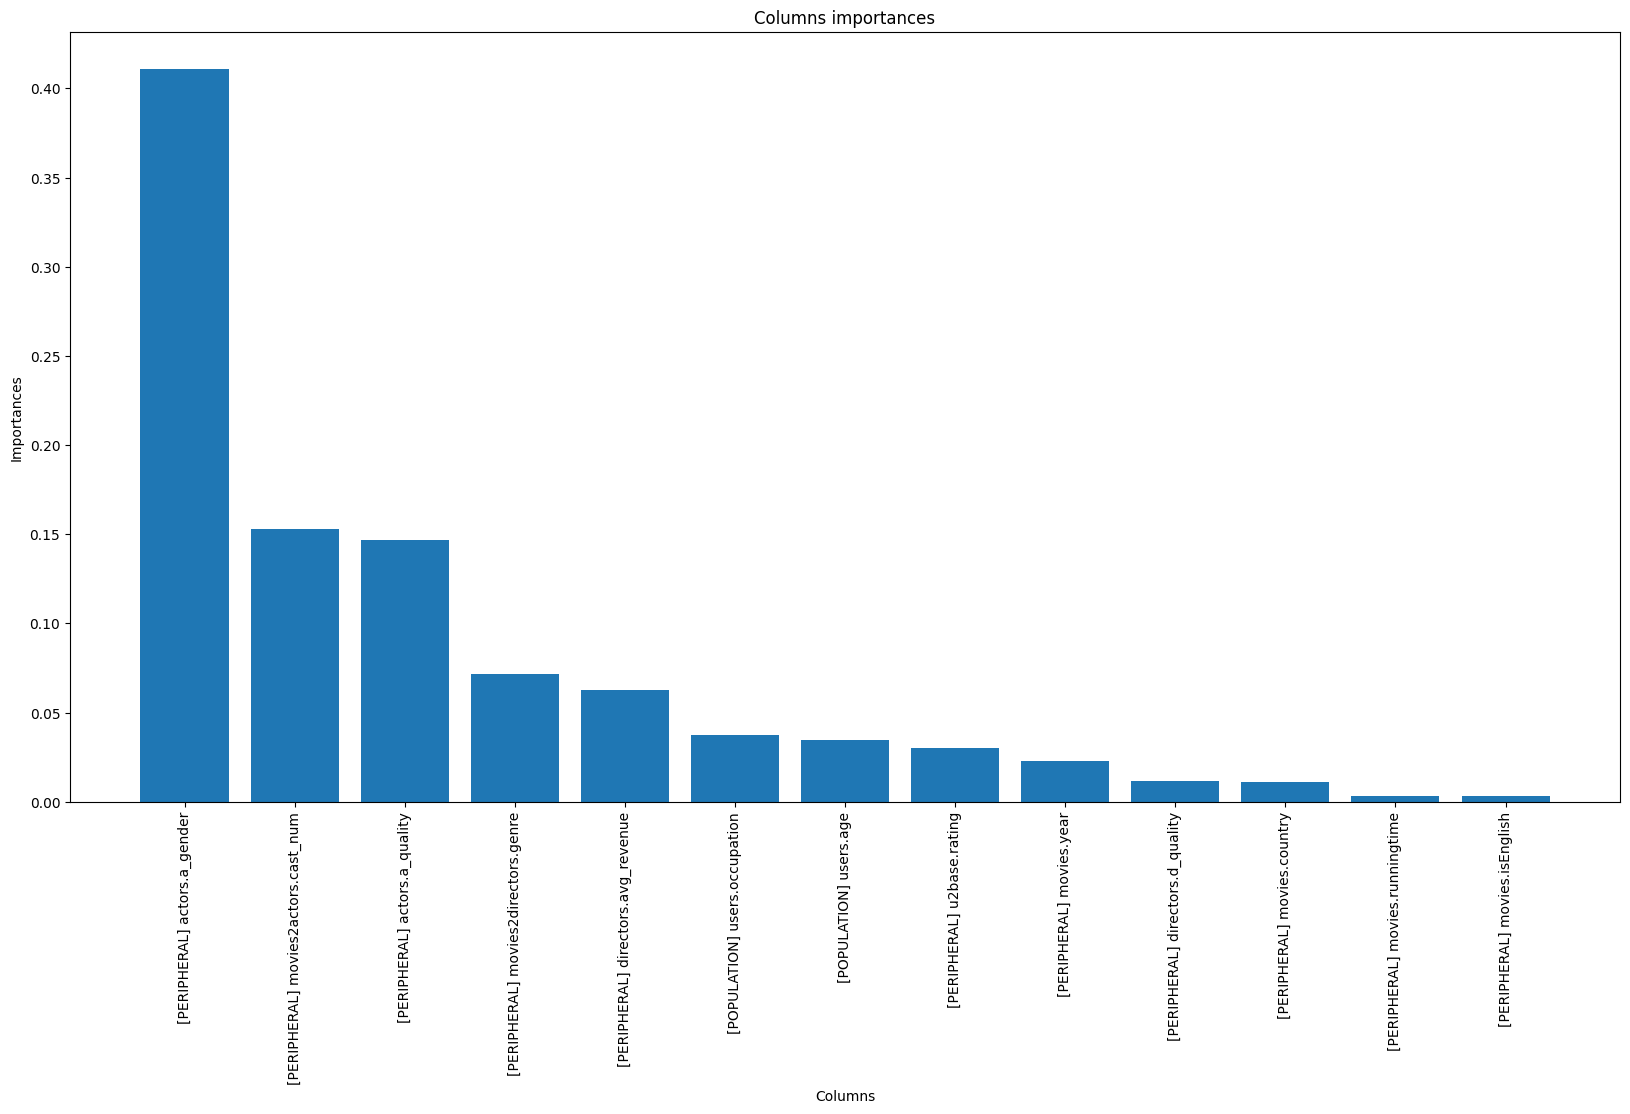

In [26]:
names, importances = pipe2.columns.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances)

plt.title('Columns importances')
plt.xlabel('Columns')
plt.ylabel('Importances')
plt.xticks(rotation='vertical')
plt.show()

#### 2.7 Features

The most important features look as follows:

In [27]:
pipe1.features.to_sql()[pipe1.features.sort(by="importances")[0].name]

```sql
DROP TABLE IF EXISTS "FEATURE_1_138";

CREATE TABLE "FEATURE_1_138" AS
SELECT MEDIAN( COALESCE( f_1_1_69."feature_1_1_69", 0.0 ) ) AS "feature_1_138",
       t1.rowid AS rownum
FROM "USERS__STAGING_TABLE_1" t1
INNER JOIN "U2BASE__STAGING_TABLE_4" t2
ON t1."userid" = t2."userid"
LEFT JOIN "FEATURE_1_1_69" f_1_1_69
ON t2.rowid = f_1_1_69.rownum
GROUP BY t1.rowid;
```

In [28]:
pipe2.features.to_sql()[pipe2.features.sort(by="importances")[0].name]

```sql
DROP TABLE IF EXISTS "FEATURE_1_1";

CREATE TABLE "FEATURE_1_1" AS
SELECT AVG( 
    CASE
        WHEN ( p_1_1."feature_1_1_69" > 0.242159 ) AND ( p_1_1."feature_1_1_21" > 0.232813 ) AND ( t2."t3__year__mapping_1_target_1_avg" > 0.282119 ) THEN 20.46317569156853
        WHEN ( p_1_1."feature_1_1_69" > 0.242159 ) AND ( p_1_1."feature_1_1_21" > 0.232813 ) AND ( t2."t3__year__mapping_1_target_1_avg" <= 0.282119 OR t2."t3__year__mapping_1_target_1_avg" IS NULL ) THEN 7.321538279840953
        WHEN ( p_1_1."feature_1_1_69" > 0.242159 ) AND ( p_1_1."feature_1_1_21" <= 0.232813 OR p_1_1."feature_1_1_21" IS NULL ) AND ( p_1_1."feature_1_1_69" > 0.243429 ) THEN 5.046599618766721
        WHEN ( p_1_1."feature_1_1_69" > 0.242159 ) AND ( p_1_1."feature_1_1_21" <= 0.232813 OR p_1_1."feature_1_1_21" IS NULL ) AND ( p_1_1."feature_1_1_69" <= 0.243429 OR p_1_1."feature_1_1_69" IS NULL ) THEN -8.250725468943104
        WHEN ( p_1_1."feature_1_1_69" <= 0.242159 OR p_1_1."feature_1_1_69" IS NULL ) AND ( p_1_1."feature_1_1_21" > 0.273123 ) AND ( p_1_1."feature_1_1_76" > 0.008673 ) THEN -3.885674068832839
        WHEN ( p_1_1."feature_1_1_69" <= 0.242159 OR p_1_1."feature_1_1_69" IS NULL ) AND ( p_1_1."feature_1_1_21" > 0.273123 ) AND ( p_1_1."feature_1_1_76" <= 0.008673 OR p_1_1."feature_1_1_76" IS NULL ) THEN -12.86974979841147
        WHEN ( p_1_1."feature_1_1_69" <= 0.242159 OR p_1_1."feature_1_1_69" IS NULL ) AND ( p_1_1."feature_1_1_21" <= 0.273123 OR p_1_1."feature_1_1_21" IS NULL ) AND ( p_1_1."feature_1_1_85" > 0.003477 ) THEN 26.50336909269918
        WHEN ( p_1_1."feature_1_1_69" <= 0.242159 OR p_1_1."feature_1_1_69" IS NULL ) AND ( p_1_1."feature_1_1_21" <= 0.273123 OR p_1_1."feature_1_1_21" IS NULL ) AND ( p_1_1."feature_1_1_85" <= 0.003477 OR p_1_1."feature_1_1_85" IS NULL ) THEN -2.663699179011978
        ELSE NULL
    END
) AS "feature_1_1",
       t1.rowid AS rownum
FROM "USERS__STAGING_TABLE_1" t1
INNER JOIN "U2BASE__STAGING_TABLE_4" t2
ON t1."userid" = t2."userid"
LEFT JOIN "FEATURES_1_1_PROPOSITIONALIZATION" p_1_1
ON t2.rowid = p_1_1."rownum"
GROUP BY t1.rowid;
```

#### 2.8 Productionization

It is possible to productionize the pipeline by transpiling the features into production-ready SQL code. Please also refer to getML's `sqlite3` and `spark` modules.

In [29]:
# Creates a folder named movie_lens_pipeline containing
# the SQL code.
pipe2.features.to_sql().save("movie_lens_pipeline")

In [30]:
pipe2.features.to_sql(dialect=getml.pipeline.dialect.spark_sql).save("movie_lens_spark")

#### 2.9 Benchmarks

State-of-the-art approaches on this dataset perform as follows:


| Approach                          | Study                       | Accuracy     | AUC     |
| :------------------------------   | :-------------------------  | -----------: | ------: |
| Probabalistic Relational Model    | Ghanem (2009)               | --           |  69.2%  |
| Multi-Relational Bayesian Network | Schulte and Khosravi (2012) | 69%          |  --     |
| Multi-Relational Bayesian Network | Schulte et al (2013)        | 66%          |  --     |


By contrast, getML's algorithms, as used in this notebook, perform as follows:

In [31]:
scores = [fastprop_score, relboost_score]
pd.DataFrame(data={
    'Approach': ['FastProp', 'Relboost'],
    'Accuracy': [f'{score.accuracy:.1%}' for score in scores],
    'AUC': [f'{score.auc:,.1%}' for score in scores]
})

,Approach,Accuracy,AUC
0,FastProp,77.8%,79.0%
1,Relboost,81.0%,84.1%


### 3. Conclusion

In this notebook we have demonstrated how getML can be applied to the MovieLens dataset. We have demonstrated the our  approach outperforms state-of-the-art relational learning algorithms.

## References

Motl, Jan, and Oliver Schulte. "The CTU prague relational learning repository." arXiv preprint arXiv:1511.03086 (2015).

Ghanem, Amal S. "Probabilistic models for mining imbalanced relational data." Doctoral dissertation, Curtin University (2009).

Schulte, Oliver, and Hassan Khosravi. "Learning graphical models for relational data via lattice search." Machine Learning 88.3 (2012): 331-368.

Schulte, Oliver, et al. "A hierarchy of independence assumptions for multi-relational Bayes net classifiers." 2013 IEEE Symposium on Computational Intelligence and Data Mining (CIDM). IEEE, 2013.
